In [17]:
import numpy as np
from scipy.optimize import minimize, Bounds
from scipy.optimize import NonlinearConstraint, LinearConstraint

import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
import warnings
warnings.filterwarnings("ignore")

## Model Formulation

In [19]:
# Model Formulation

R = 2 # Arbitrary constant

def objective_fun(X):
    sum = 0
    for q in X:
        sum += ((q**2) * R)
    return sum

def generate_timepoint_h2_level_constraint(j, arr_len):
    first_part = np.full(j + 1, 1)
    second_part = np.full((arr_len - 1) - j, 0)

    return np.concatenate((first_part, second_part))

def controller(h2_demands_in, storage_limit):
    
    X0 = np.zeros(h2_demands_in.shape[0]) # Initial guess for X
    max_tank_size = storage_limit

    demands_arr_len = h2_demands_in.shape[0]
    
    h2_level_constraints = []
    for j in range(demands_arr_len):
        # constraints.append(LinearConstraint(generate_timepoint_h2_level_constraint(j), np.sum(B[:j + 1]), np.inf))
        h2_level_constraints.append(
            LinearConstraint(generate_timepoint_h2_level_constraint(j, demands_arr_len),
                             np.sum(h2_demands_in[:j + 1]),
                             np.sum(h2_demands_in[:j + 1]) + max_tank_size)
        )

    production_rate_bounds = Bounds(0, np.inf)
    
    # Solve the minimization problem using trust-constr
    result = minimize(objective_fun, X0, method='trust-constr', constraints = h2_level_constraints, bounds = production_rate_bounds,
                      options={'verbose': 1, 'maxiter': 1000, 'disp': True})
    return result.x

## Model Execution

`xtol` termination condition is satisfied.
Number of iterations: 75, function evaluations: 310, CG iterations: 80, optimality: 1.36e-06, constraint violation: 0.00e+00, execution time: 0.039 s.
`xtol` termination condition is satisfied.
Number of iterations: 97, function evaluations: 445, CG iterations: 130, optimality: 1.81e-05, constraint violation: 0.00e+00, execution time: 0.05 s.
`gtol` termination condition is satisfied.
Number of iterations: 26, function evaluations: 90, CG iterations: 39, optimality: 6.83e-09, constraint violation: 0.00e+00, execution time: 0.016 s.
`gtol` termination condition is satisfied.
Number of iterations: 36, function evaluations: 185, CG iterations: 71, optimality: 2.18e-09, constraint violation: 0.00e+00, execution time: 0.015 s.
`gtol` termination condition is satisfied.
Number of iterations: 8, function evaluations: 40, CG iterations: 17, optimality: 4.46e-09, constraint violation: 0.00e+00, execution time: 0.016 s.
`gtol` termination condition is s

Text(0.5, 1.0, 'Demand and production rates vs Time')

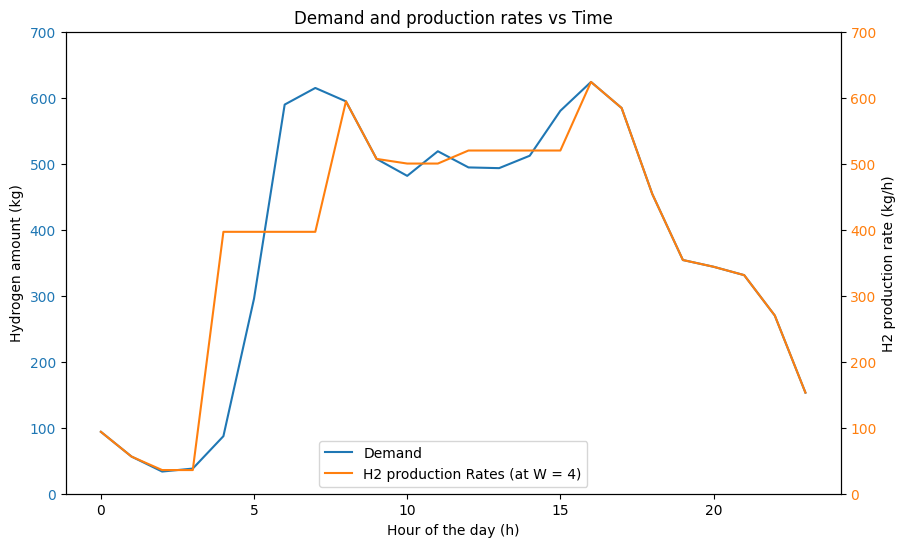

In [20]:
# Model Execution

real_data = np.array([938, 563, 336, 381, 872, 2957,
                      5896, 6148, 5945, 5073, 4816, 5189,
                     4944, 4933, 5121, 5802, 6239, 5844,
                     4542, 3541, 3439, 3312, 2700, 1532])

# The raw data is hourly traffic volume in a highway. Since I 
# only need to use the distribution to simulate how busy a particular hour of the
# day is, I am multiplying the raw data by a factor (here it is 0.1) to roughly estimate
# the hourly hydorgen demand for a small fuel station.

h2_demands = real_data * 0.1

def sim_small_window(window):
    l = 0
    
    ls = []
    
    rates = []
    
    w = window
    
    j = 0
    while j < h2_demands.shape[0]:
        h2_future_levels = h2_demands[j : j + w]
        out = controller(h2_future_levels, 5000) # testing with storage limit 5000
        for p in range(len(out)):
            l += out[p]
            l -= h2_demands[j]
            ls.append(l)
            rates.append(out[p])
            j += 1
    return rates
    
t = np.array(range(0, 24))

# print(rates)
# for i in range(w-1):
#     rates.append(0)
# rates.append(0)

# plt.plot(t, B, label = "main_demand")
# plt.plot(t, sim_small_window(12), label = "modified_demand")

fig, ax1 = plt.subplots(figsize = (10, 6))

color = "tab:blue"

ax1.set_xlabel("Hour of the day (h)")
ax1.set_ylabel("Hydrogen amount (kg)")
ax1.plot(t, h2_demands, label = "Demand", color = color)
# ax1.plot(t, r_l_inf, label = "H2 production Rates", color = color)
ax1.tick_params(axis = 'y', labelcolor = color)

# ax1.legend(loc = "upper left")

ax1.set_ylim(0, 700)

ax2 = ax1.twinx()

color2 = "tab:orange"

ax2.set_ylabel("H2 production rate (kg/h)")
# ax2.plot(t, sim_small_window(12), label = "H2 production Rates (at W = 12)", color = color2)
# ax2.plot(t, sim_small_window(8), label = "H2 production Rates (at W = 8)", color = color2)
ax2.plot(t, sim_small_window(4), label = "H2 production Rates (at W = 4)", color = color2)
# ax2.plot(t, sim_small_window(2), label = "H2 production Rates (at W = 2)", color = color2)
# ax2.plot(t, r_l_100, label = "H2 production Rates (at C = 100)")
ax2.tick_params(axis = 'y', labelcolor = color2)

ax2.set_ylim(0, 700)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax2.legend(lines + lines2, labels + labels2, loc = "lower center")

# fig.tight_layout()
plt.title("Demand and production rates vs Time")

# plt.savefig("window_change_w_2.png", dpi = 300)